# Firms population


In [1]:
#Load modules

import pandas as pd
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from numpy import log10
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Load data
### Here we load the data aggregated at (firm, year, flow) level. The only variable we know for each (firm, year, flow) is the 'VART_sum', that is, the sum of transaction values at border.

In [2]:

drive_path = './../../../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

firm_mx_y = pd.read_csv(drive_path+'/samplings/full_firm_mx_yr.csv')

In [3]:
#Sample of the loaded dataset

ix = ['ID', 'IMPORT', 'YEAR']
display(firm_mx_y.sort_values(by = ix).head(20).set_index(ix))
print '...'

VART_sum
ID IMPORT YEAR          
0  0      1997  39913032
          1998  25985808
          1999  44626344
          2000  15188499
          2001  60013092
          2002  16027572
          2003  10909484
          2004  17354863
          2005   8502114
          2006  14040307
          2007  14002190
          2008  51185304
          2009   9799932
          2010  97361175
          2011   1435637
          2012    131222
          2013      1109
   1      1997  46236989
          1998  29903677
          1999  51071786

...


### how does the distribution of firm sizes, by exports (blue) and imports (green) evolve over time?


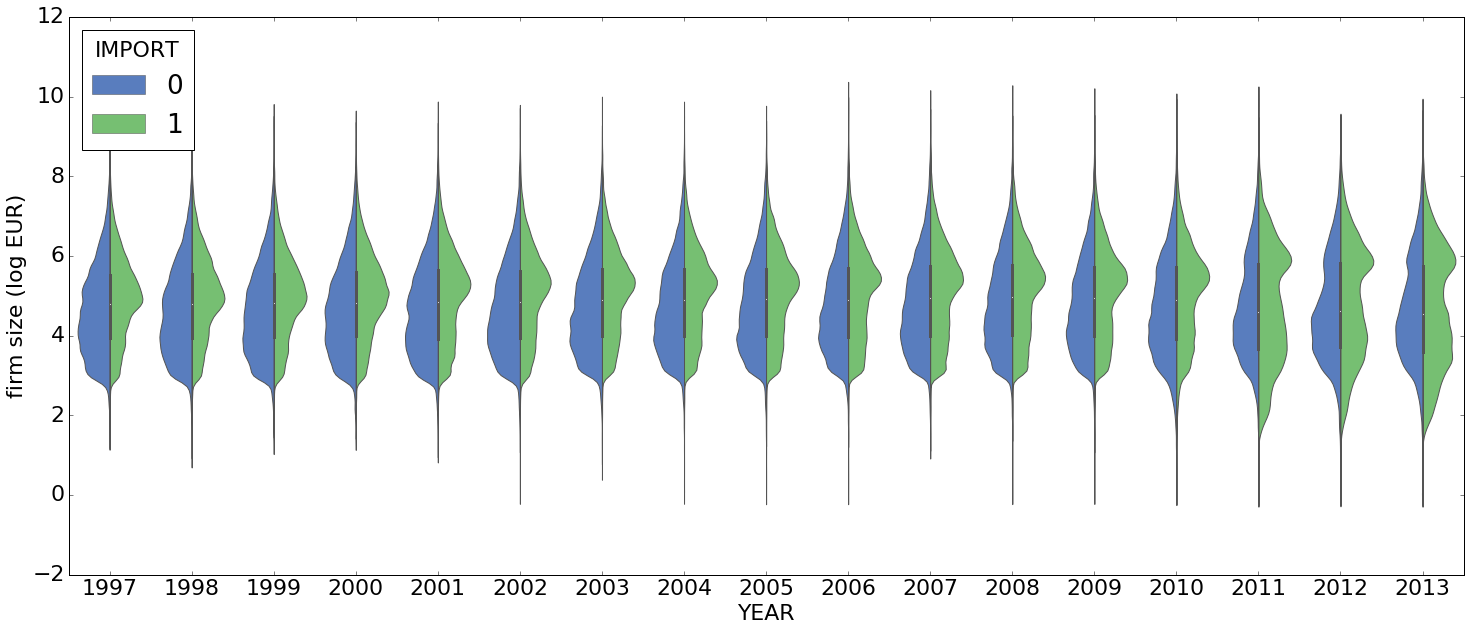

In [4]:
matplotlib.rcParams.update({'font.size': 22})

df = firm_mx_y.sample(frac = .1)
df['log_VART_sum'] = log10(df['VART_sum'])
df = df[['IMPORT', 'log_VART_sum','YEAR']].reset_index(drop = True).replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(1, figsize = (25, 10))

ax = sns.violinplot(x="YEAR", y="log_VART_sum", hue="IMPORT", data=df, palette="muted", split=True, scale="count", bw=.1)
ax.set_ylabel('firm size (log EUR)')

In [5]:
display(HTML("<style>.container { width:100% !important; }</style>"))

## Entry and exit dynamics

In [6]:
# Calculate 'age' of firms as years after first non-zero record. Firms active in the first three years are discarded. 
# Inverse age is defined simetrically to age. It's the years before last non-zero record of a firm. Firms active in last 3 years of the sample are discarded.

for inv_age in [False, True]:
    age_list = []

    for i in [0, 1]:

        firm_y = firm_mx_y.loc[firm_mx_y.IMPORT == i]

#         firm_y = firm_mx_y.loc[firm_mx_y.ID.isin(firm_stats[(firm_stats['IMPORT'] == 0) & abs(firm_stats['p50'] - 5) < 0.2].index.values)].loc[firm_mx_y.IMPORT == i]
        firm_y_uns = firm_y.loc[firm_y.IMPORT == i].set_index(['ID', 'YEAR'])[['VART_sum']].unstack()
        firm_y_uns.columns = firm_y_uns.columns.droplevel(0)

        if inv_age:
            firm_y_uns = firm_y_uns[list(reversed(firm_y_uns.columns))]
        

        n = firm_y_uns.notnull()
        c = n.cumsum(axis = 1)
        age = pd.DataFrame(c[n].stack())
        age.columns = ['age'] #max at 1997 is 1
        age['IMPORT'] = i
        age.reset_index(inplace = True)

        age_list += [age]
    
    if inv_age:
        inv_age = pd.concat(age_list)
        inv_age['age'] = - inv_age['age']
        firm_y_inv_age = firm_mx_y.merge(inv_age, on = ['ID', 'IMPORT', 'YEAR'])

    else:
        age = pd.concat(age_list)
        firm_y_age = firm_mx_y.merge(age, on = ['ID', 'IMPORT', 'YEAR'])


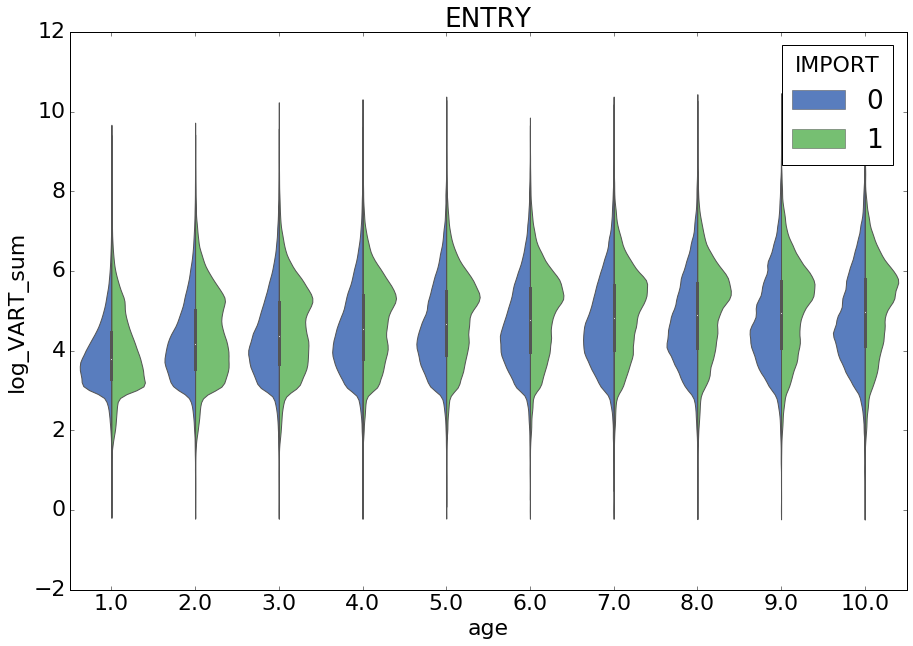

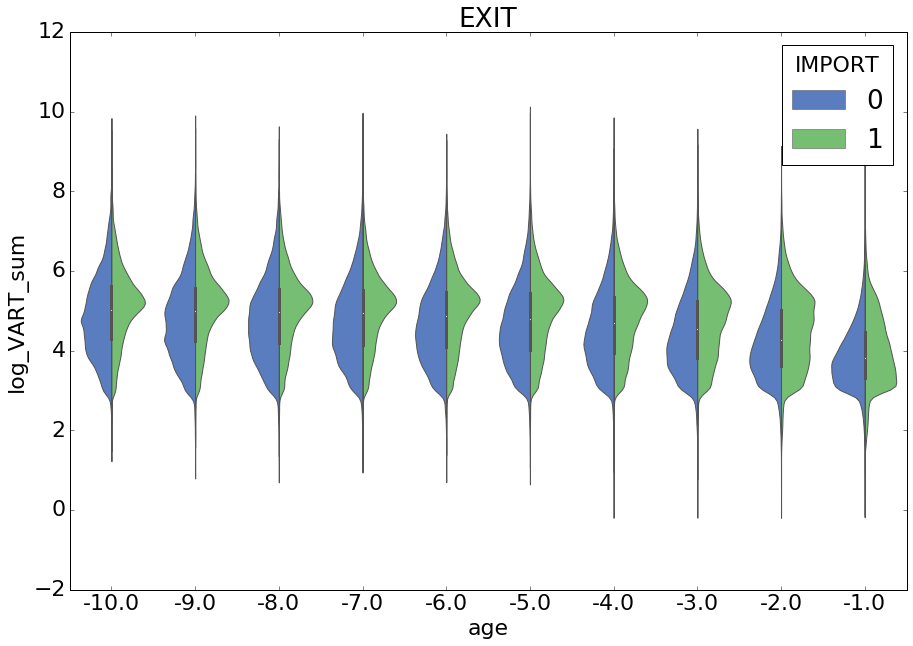

In [7]:
entry = firm_y_age[(firm_y_age['YEAR'] - firm_y_age['age'] > 1998) & (firm_y_age['age'] <= 10)]
exit = firm_y_inv_age[(firm_y_inv_age['YEAR'] - firm_y_inv_age['age'] < 2014) & (firm_y_inv_age['age'] >= -10)]

for i in [0, 1]:
    data = [entry, exit][i]
    df = data.groupby('age').apply(lambda x: x.sample(frac = .5, replace = True))
    df['log_VART_sum'] = log10(df['VART_sum'])
    df = df[['IMPORT', 'log_VART_sum','age']].reset_index(drop = True).replace([np.inf, -np.inf], np.nan).dropna()

    fig, ax = plt.subplots(1, figsize = (15, 10))

    ax = sns.violinplot(x="age", y="log_VART_sum", hue="IMPORT", data=df, palette="muted", split=True, scale="count", bw=.1)
    if i: ax.set_title('EXIT')
    else: ax.set_title('ENTRY')
    
